# STARDUST tutorial

STARDUST (Subcellular-level Tool for Analyzing RNA Distribution USing optimal Transport) is a method for analyzing the subcellular spatial distribution of RNA molecules.

In [ ]:
from stardust import *
import scanpy as sc
import seaborn as sns

## De novo analysis

De novo analysis identifies the axes of variation in how one or more genes' transcripts are distributed in cells in a dataset. When multiple genes of interest are given, the model distinguishes between transcripts from differen genes and takes into account gene-gene spatial correlations.

### One gene

We'll start by analyzing the variation in how one gene's transcripts are distributed in different cells.

We'll generate some simulated data to use for the purpose of this tutorial. (The simulate_data function uses the simfish package (https://github.com/fish-quant/sim-fish). Valid patterns to simulate include 'intranuclear', 'perinuclear', 'nuclear_edge', 'extranuclear', 'pericellular', 'cell_edge', 'foci', and 'protrusion'.)

To run STARDUST your own spatial transcriptomics data, simply format your data as a DataFrame where each row is a single detected RNA molecule. The DataFrame should have columns 'cell' (cell ID the transcript is assigned to), 'gene' (gene of transcript), 'x', 'y' (spatial coordinates of the transcript).


In [ ]:
templates_path = '/data/peer/chene5/subcellular/simfish/templates' # Path to simfish templates

sim_data = simulate_data(templates_path, n_cells=20, n_spots=40, proportion_pattern=0.9, patterns = ['intranuclear', 'perinuclear', 'pericellular', 'extranuclear', 'foci'])

Create a Stardust model that wraps the data and run de novo analysis with a list of cells and the gene of interest to analyze.

In [ ]:
model = Stardust(sim_data)

model.de_novo_analysis(cells = sim_data['cell'].unique(), 
                       genes_of_interest = ['simulated'])

Generate an embedding of the cells based on their similarity in subcellular transcript distribution.

/lila/home/chene5/stardust/.venv/lib/python3.12/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


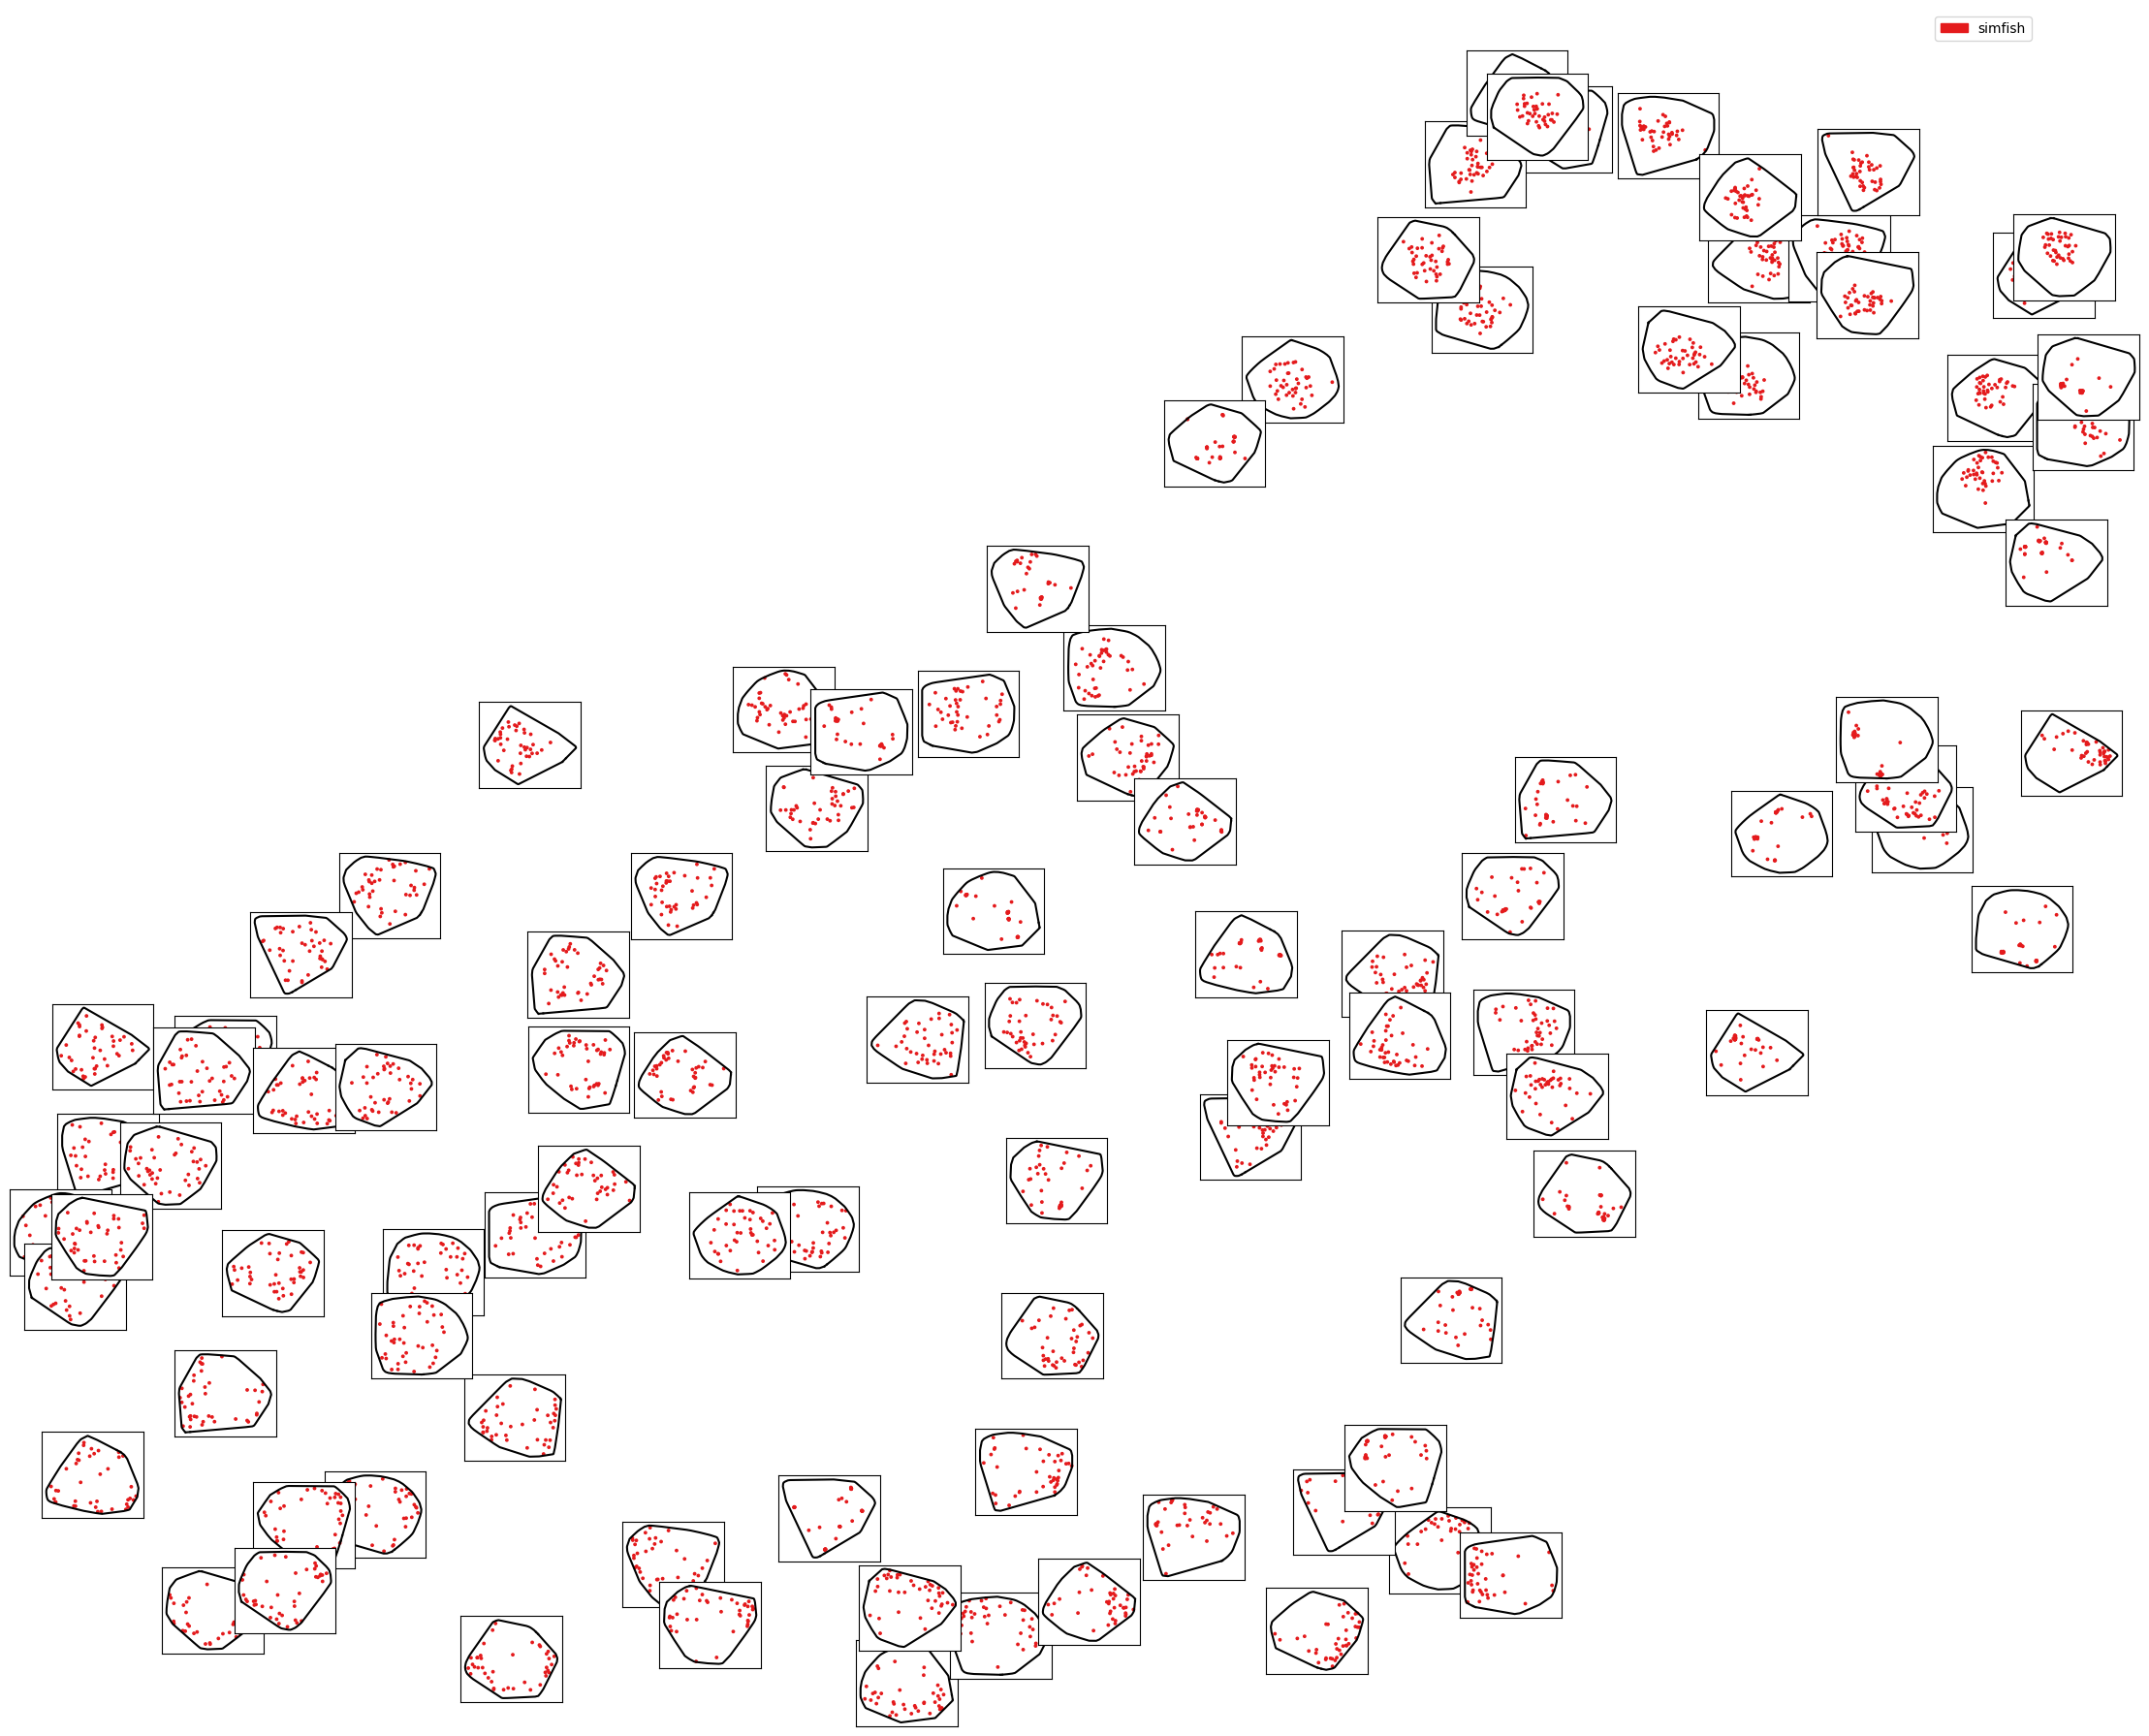

In [ ]:
model.UMAP_de_novo_analysis_output()

### Multiple genes

We can also compare cells based on the subcellular distribution of multiple genes' transcripts.

First generate simulated data with multiple genes.

In [8]:
sim_data_2 = simulate_multi_genes_data(templates_path, n_genes=2)

The only difference from before is that we specify multiple genes as the genes of interest.

/lila/home/chene5/stardust/.venv/lib/python3.12/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


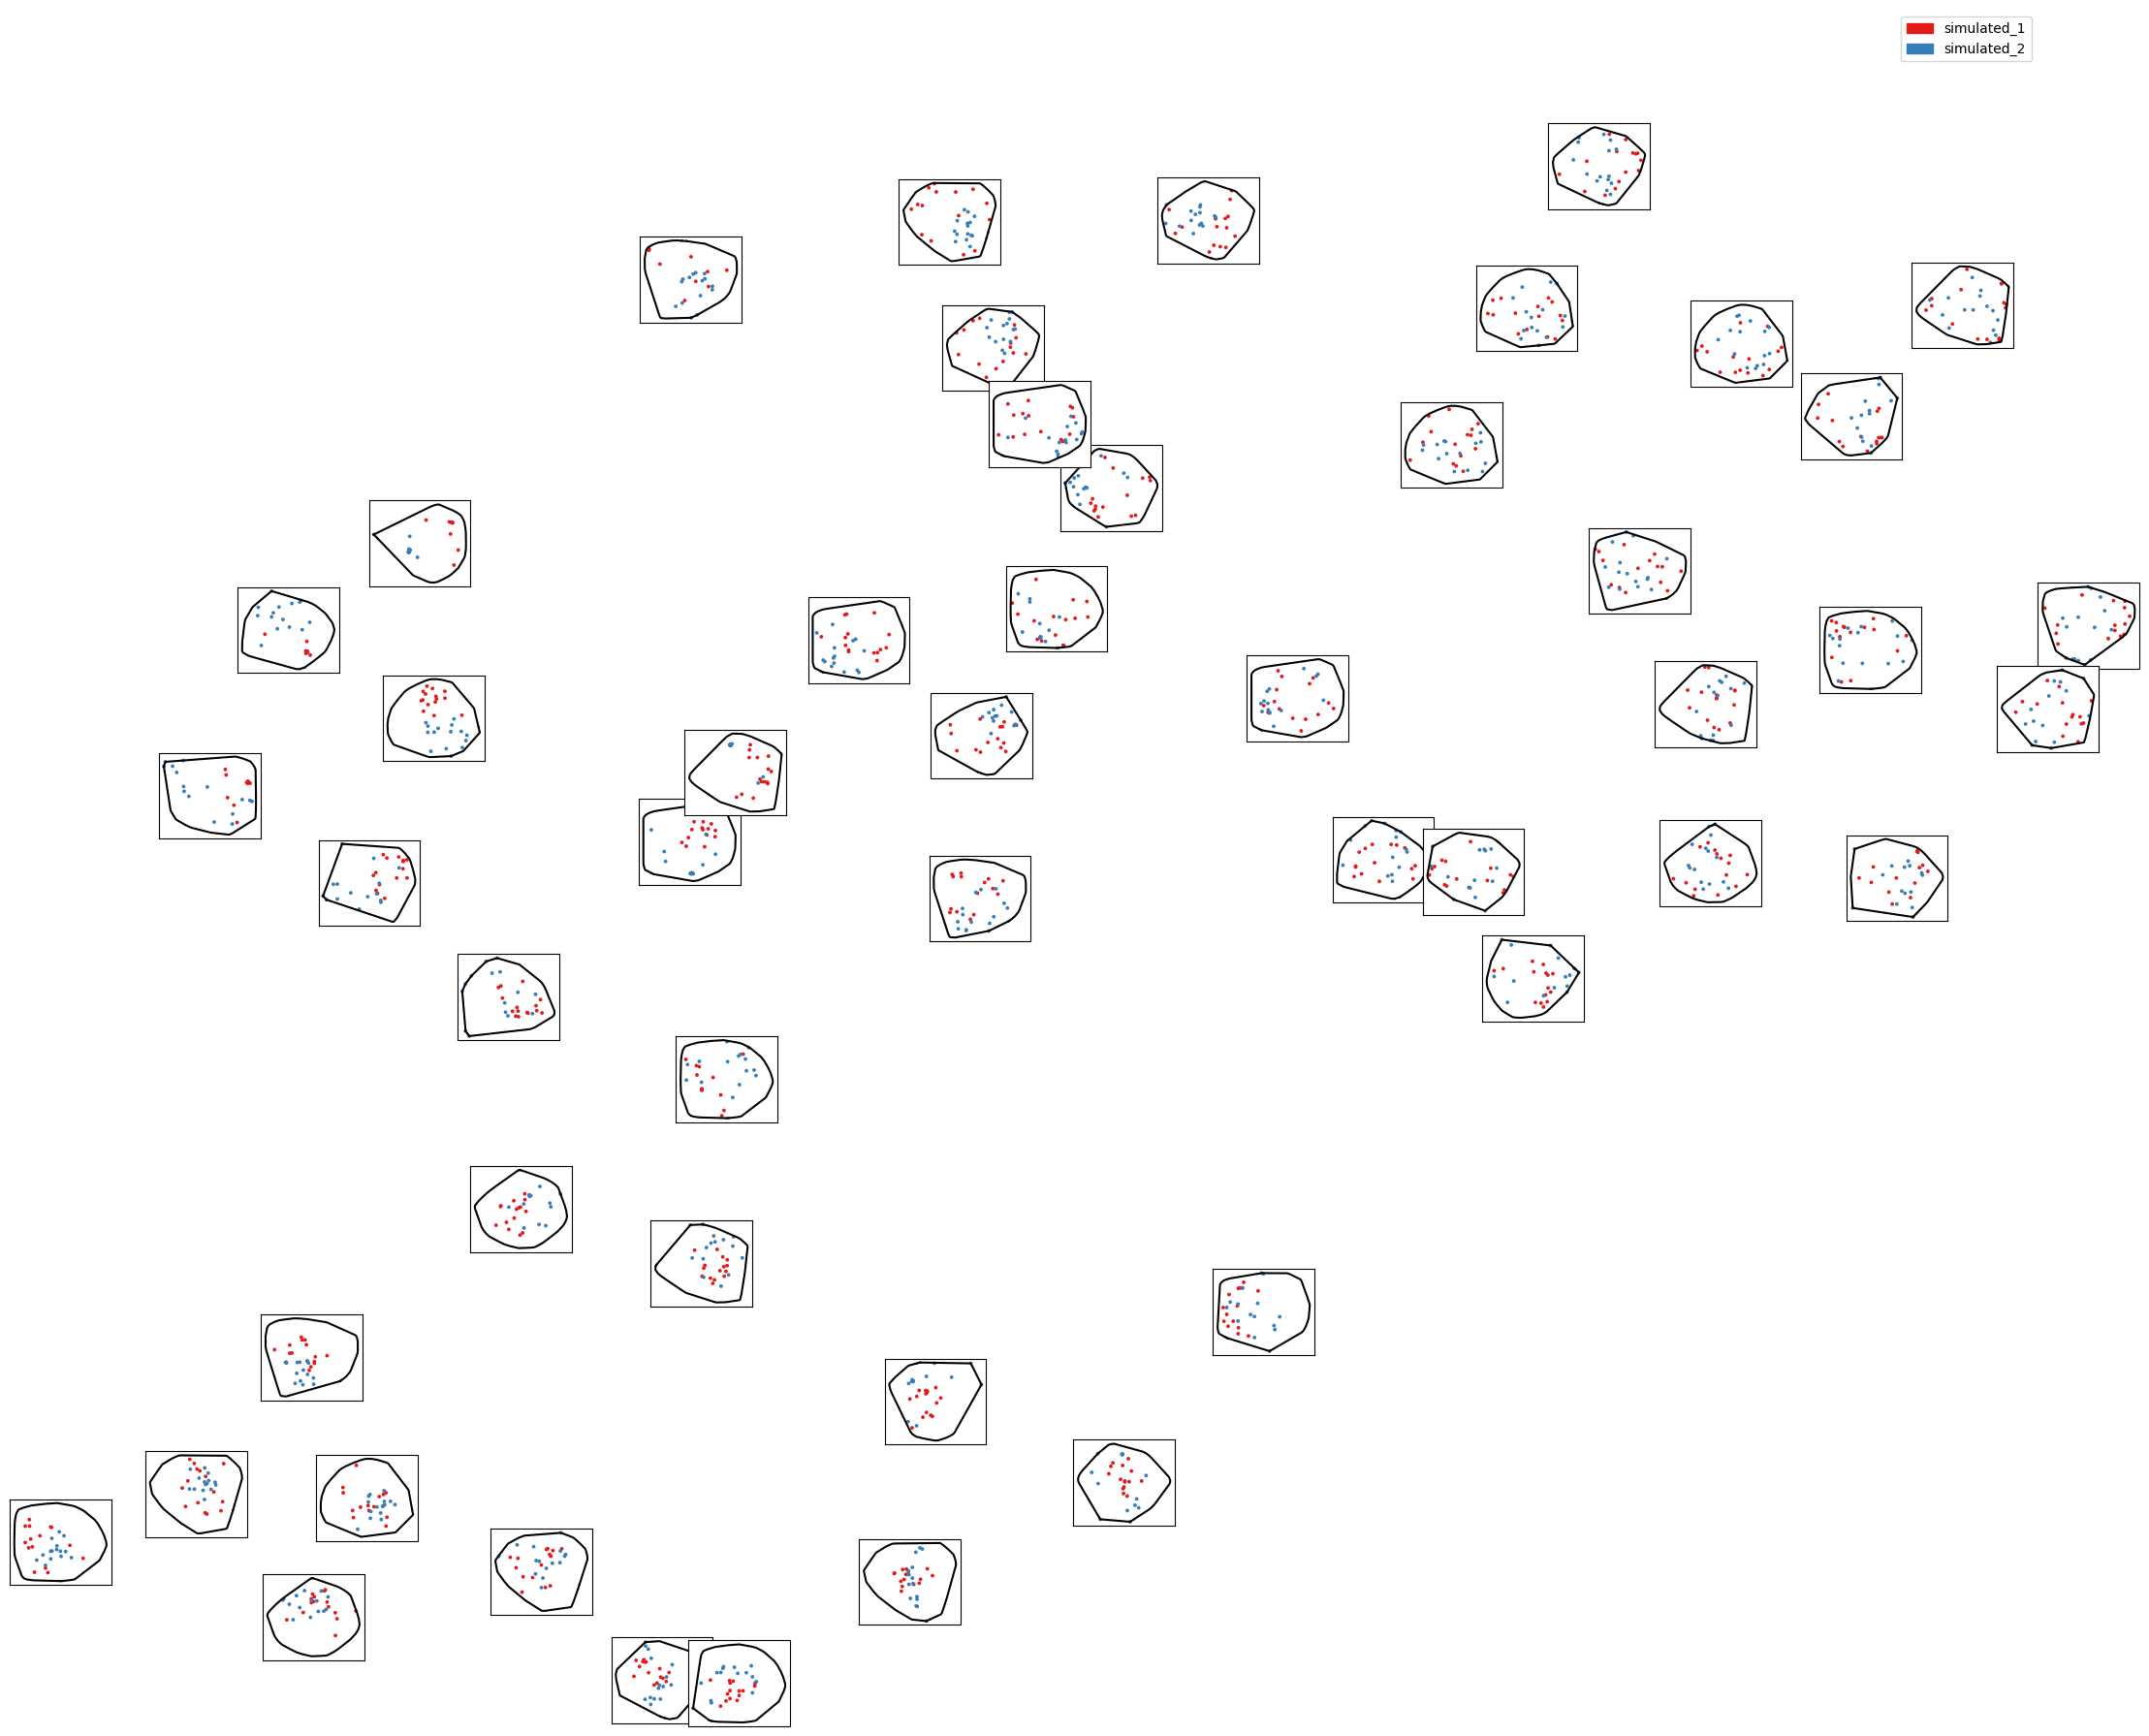

In [ ]:
model2 = Stardust(sim_data_2)
model2.de_novo_analysis(cells = sim_data_2['cell'].unique(), 
                        genes_of_interest = ['simulated_1', 'simulated_2'])
model2.UMAP_de_novo_analysis_output()

We can cluster cells with similar distributions and visualize the barycenter (archetype) of each cluster. The colors show gene identity (same legend as above) while the black points mark the cell outline.

Generating barycenter for cluster 1 / 5...
Generating barycenter for cluster 2 / 5...
Generating barycenter for cluster 3 / 5...
Generating barycenter for cluster 4 / 5...
Generating barycenter for cluster 5 / 5...


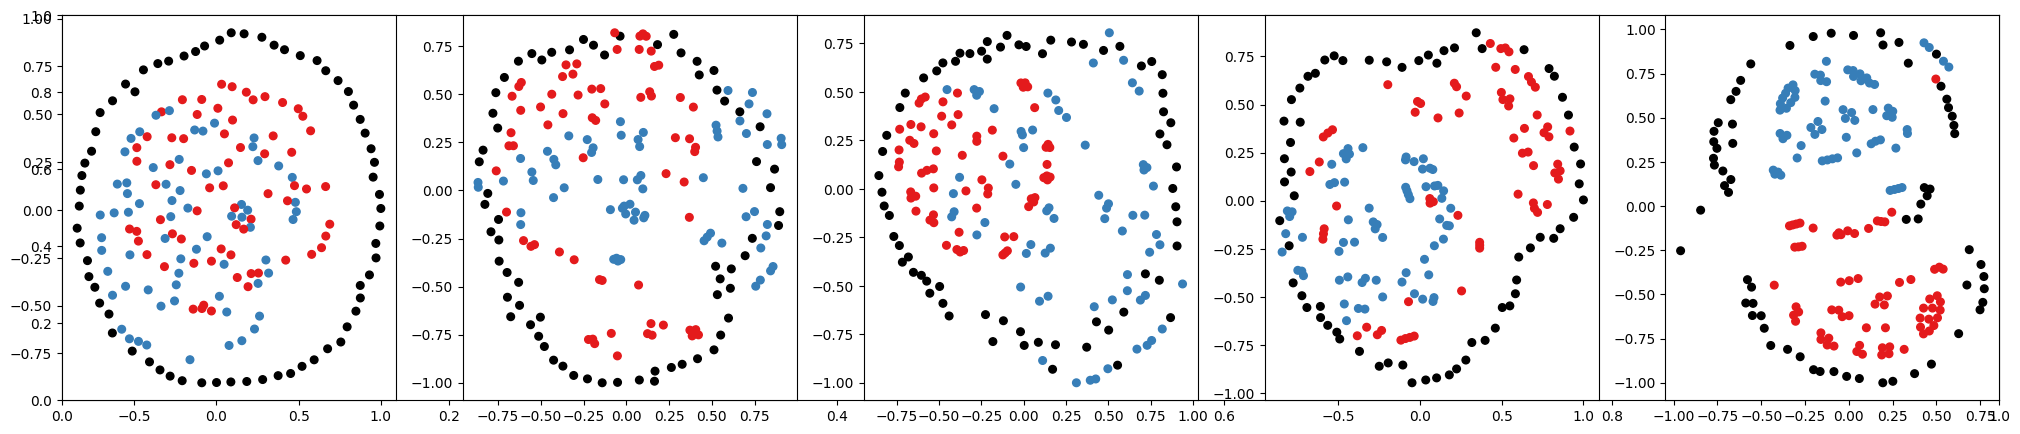

In [ ]:
model2.barycenters(n_clusters=5)

We can also see which cells in the dataset were clustered together and used to generate each archetype.

In [11]:
model2.cells_in_barycenter_clusters()

{'0': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17,
        18, 19, 21, 22, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39,
        40, 41, 43, 45, 47, 48, 49]),
 '1': array([20, 23, 24]),
 '2': array([15, 33, 46]),
 '3': array([26, 44]),
 '4': array([42])}

The process is similar for three genes...

/home/chene5/miniconda3/envs/simfish_wormhole/lib/python3.9/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


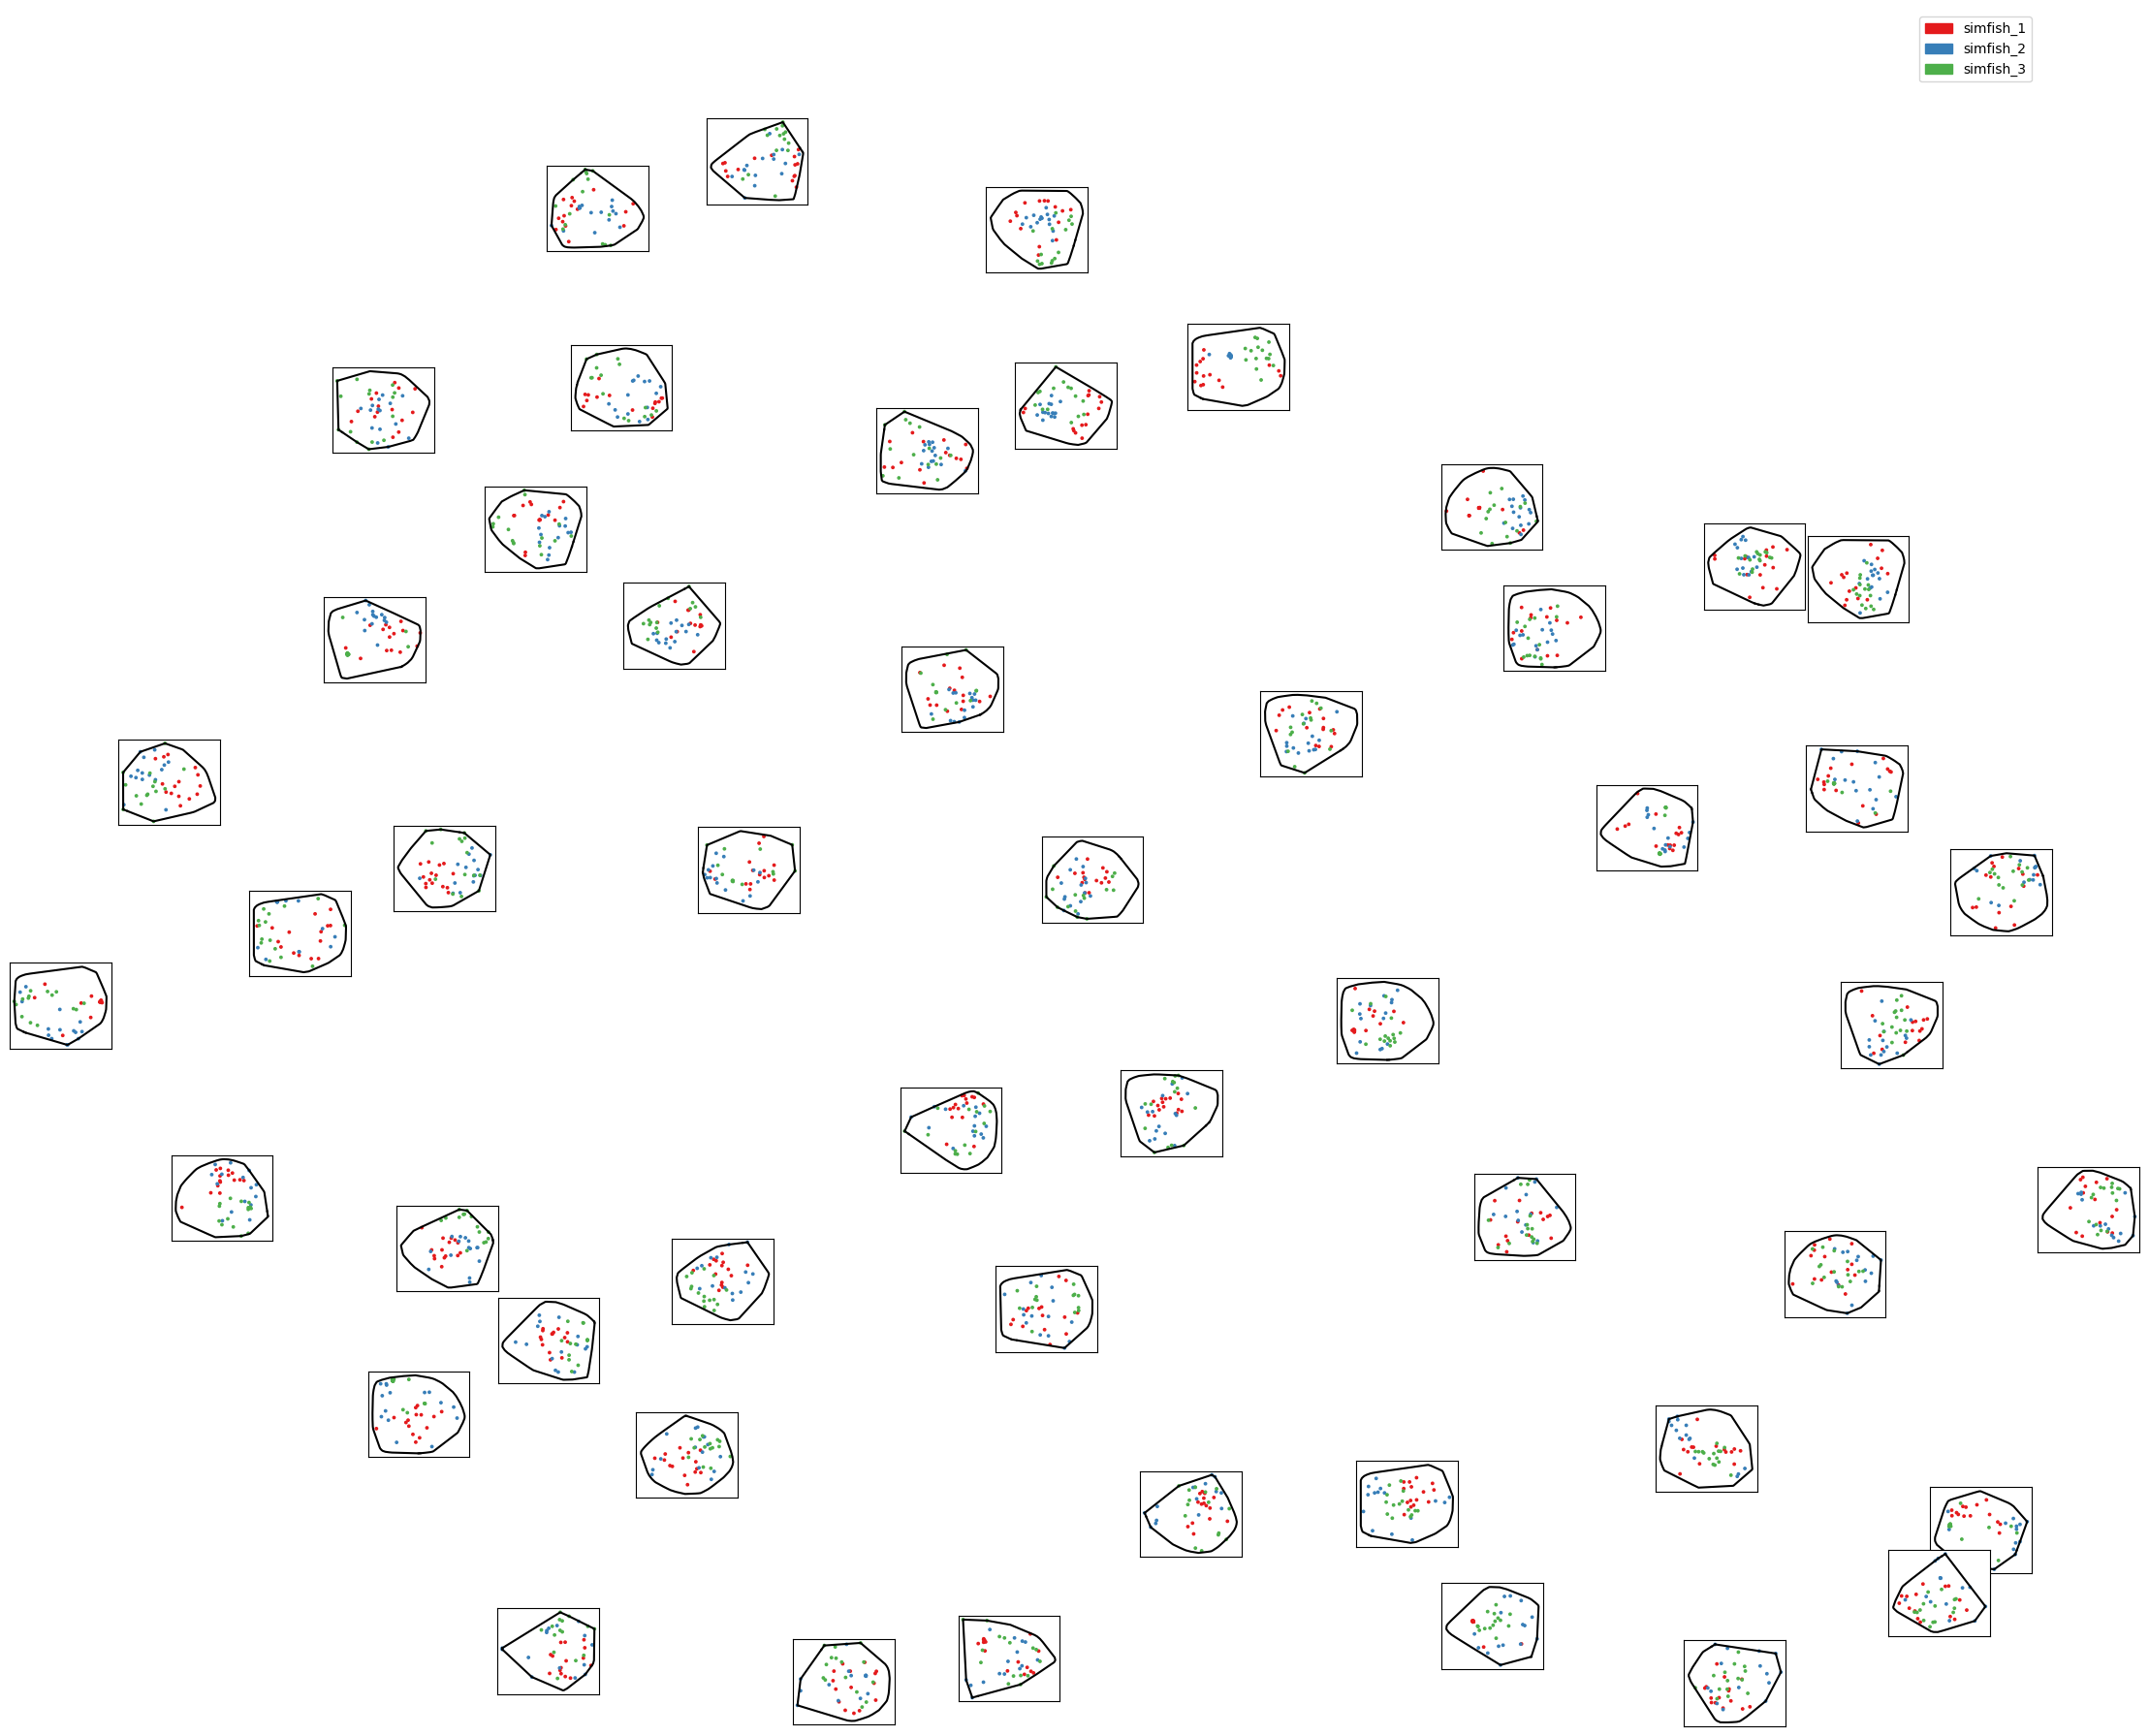

In [ ]:
sim_data_3 = simulate_multi_genes_data(templates_path, n_genes=3)

model3 = Stardust(sim_data_3)
model3.de_novo_analysis(cells = sim_data_3['cell'].unique(), 
                        genes_of_interest = ['simulated_1', 'simulated_2', 'simulated_3'])
model3.UMAP_de_novo_analysis_output()

Generating barycenter for cluster 1 / 6...


Generating barycenter for cluster 2 / 6...
Generating barycenter for cluster 3 / 6...
Generating barycenter for cluster 4 / 6...
Generating barycenter for cluster 5 / 6...
Generating barycenter for cluster 6 / 6...


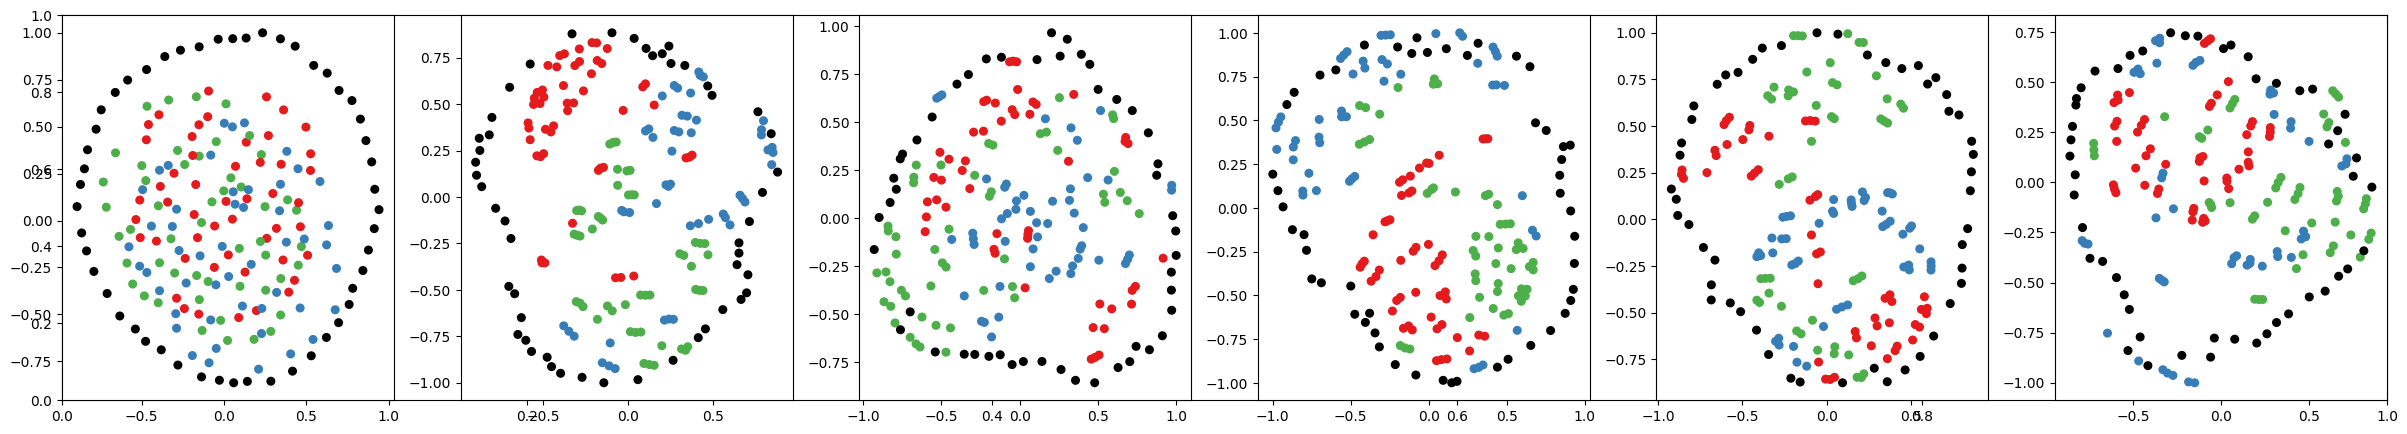

In [ ]:
model3.barycenters(n_clusters=6)

## Canonical analysis

Instead of exploring the axes of variation de novo, we can also look for canonical patterns. Canonical analysis scores transcript distributions based on how similar they are to user-specified canonicals. 

To specify the canonicals, the user can either
- supply the canonicals directly as an array of RNA coordinates (canonical_rnas) and an array of cell outline coordinates (canonical_outline) or 
- ask the model to generate canonicals of specific patterns, including 'intranuclear', 'perinuclear', 'nuclear_edge', 'extranuclear', 'pericellular', 'cell_edge', 'foci', and 'protrusion'.

Here, we will ask the model to generate the canonicals.

In [15]:
canonical_patterns = ['intranuclear', 'perinuclear', 'pericellular', 'cell_edge']

For this demo, we will use public data from "Mah, Clarence (2023). Bento Manuscript Datasets. Figshare collection. https://doi.org/10.6084/m9.figshare.c.6564043.v1". 

For the purpose of this tutorial, we will subset the data to four genes and the first 20 cells. By default, the analysis is performed for each gene's collection of transcripts in a cell. If you want to look at transcripts from multiple genes collectively, you can create a copy of the data where those genes are grouped together and given the same gene label e.g. gene_group_1.

In [ ]:
data = pd.read_csv('/data/peer/chene5/subcellular/bento/u2os_filtered/transcripts_filtered.csv')

# filter for cells with at least five transcripts of each gene of interest
genes_of_interest = ['MALAT1', 'SOD2', 'THBS1', 'TLN1']
filtered_data = data.groupby('cell').filter(lambda x: 
    (x[x['gene'] == 'MALAT1'].shape[0] > 5 and 
     x[x['gene'] == 'SOD2'].shape[0] > 5 and 
     x[x['gene'] == 'THBS1'].shape[0] > 5 and 
     x[x['gene'] == 'TLN1'].shape[0] > 5))

cells = filtered_data['cell'].unique()[:20]

The canonical analysis does take a while so a good strategy is running it on nohop and pickle-ing the output :)

In [ ]:
model = Stardust(data)
scores = model.canonical_analysis(cells, genes_of_interest, templates_path, canonical_patterns)

/lila/home/chene5/stardust/.venv/lib/python3.12/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


We can check what the canonicals used look like.

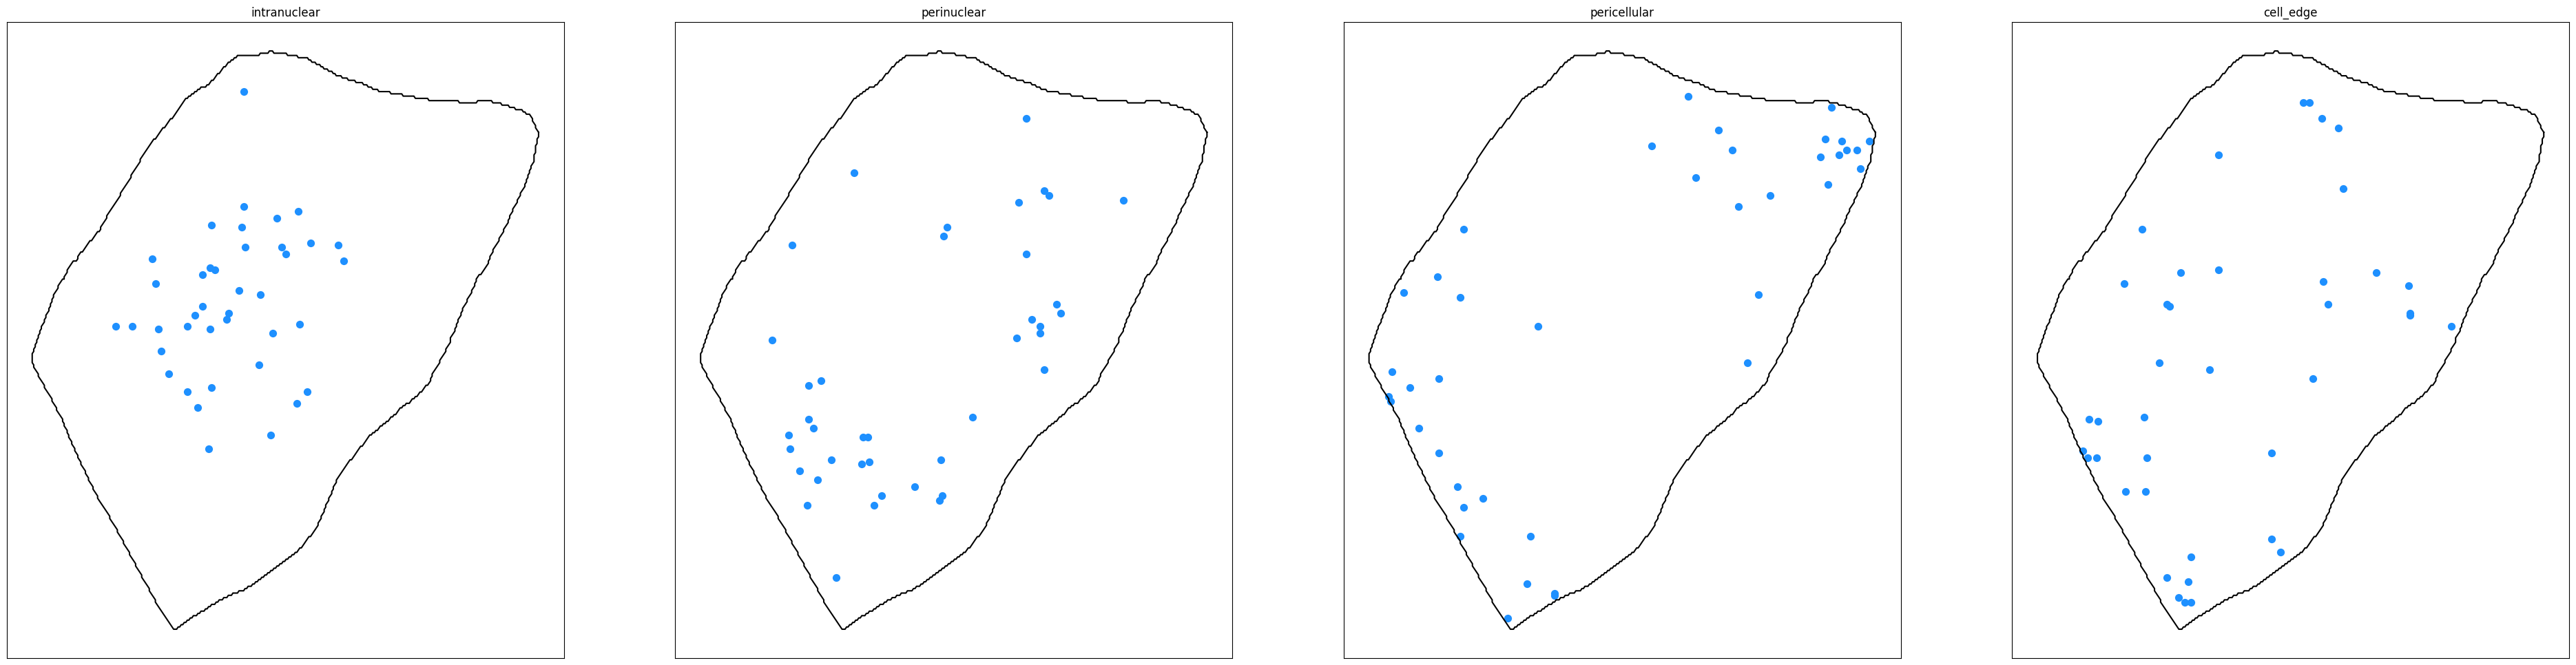

In [21]:
fig = model.show_canonicals()

For each gene in each cell, the model returns four similarity scores that tell us how similar the transcript distribution is to each of the canonicals.

In [37]:
scores

,cell,gene,intranuclear,perinuclear,pericellular,cell_edge
0,1-22,MALAT1,-378.112039,-118.765643,50.772776,446.104906
1,1-22,SOD2,3175.295782,98.240501,-2106.185127,-1167.351155
2,1-22,THBS1,143.230719,-521.824852,503.349799,-124.755666
3,1-22,TLN1,-2742.047228,-1212.391594,3941.649050,12.789772
4,10-10,MALAT1,2158.894557,45.573205,-1737.708479,-466.759284
...,...,...,...,...,...,...
75,10-6,TLN1,-2431.125311,-541.457631,3118.226577,-145.643635
76,10-61,MALAT1,1222.836442,-147.627566,-129.085177,-946.123699
77,10-61,SOD2,1796.035522,147.989036,-1608.566397,-335.458161
78,10-61,THBS1,638.409162,-450.406977,-1241.270685,1053.268500


<Axes: >

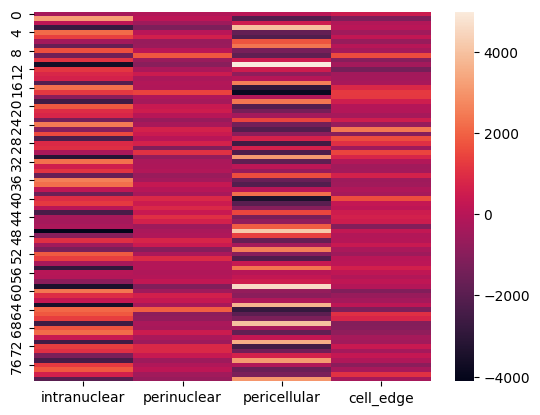

In [27]:
sns.heatmap(scores[canonical_patterns])

We can generate an embedding based on these scores. Notice how cells that are similar to the intracellular canonical are least similar to the pericellular canonical as we might expect.

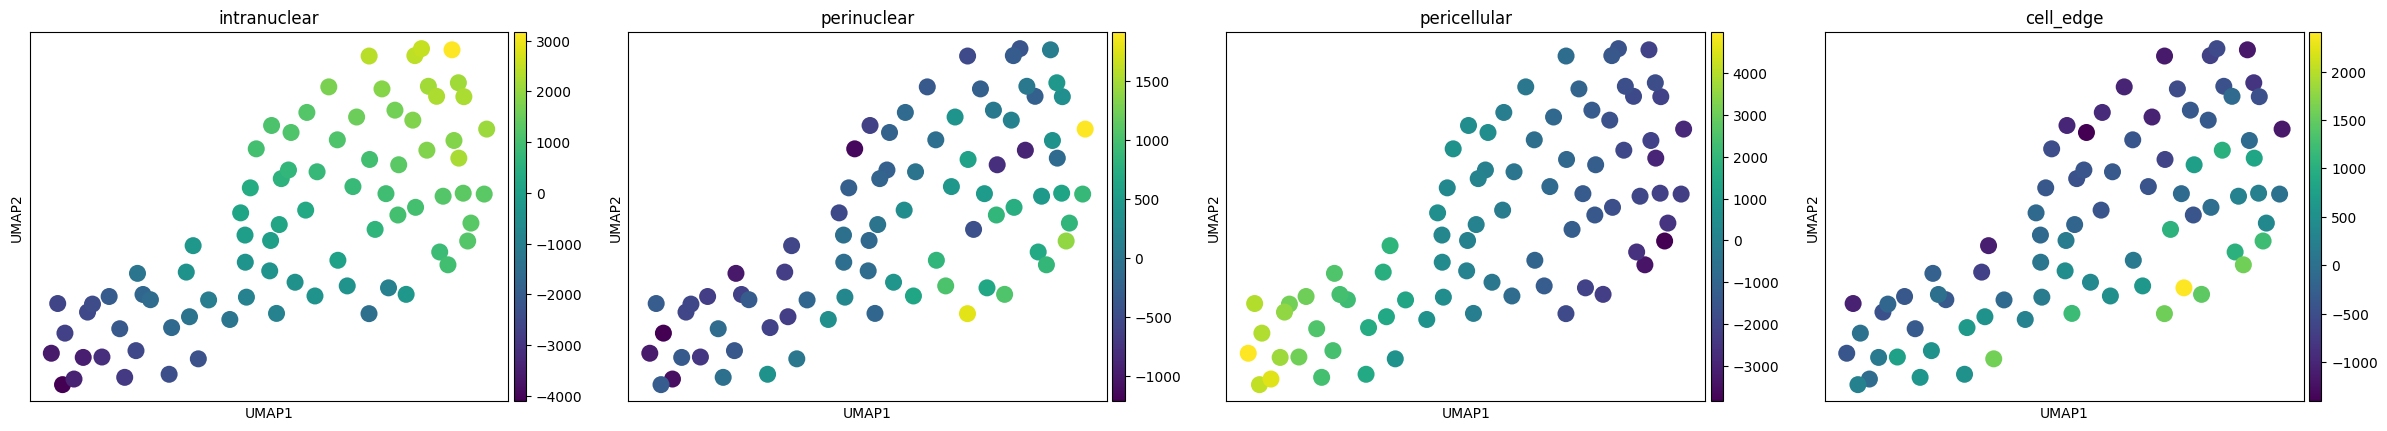

In [ ]:
ad = sc.AnnData(scores[canonical_patterns].values)
ad.obs=scores[['cell', 'gene']]
ad.var_names = canonical_patterns
sc.pp.neighbors(ad)
sc.tl.umap(ad)
sc.pl.umap(ad, color=canonical_patterns, s=600)


If we look at the cell and gene identities of these transcript distributions, we can see that certain genes have characteristic subcellular distribution patterns. For instance, MALAT1, a nuclear lnRNA, is often distributed in an intracellular manner.

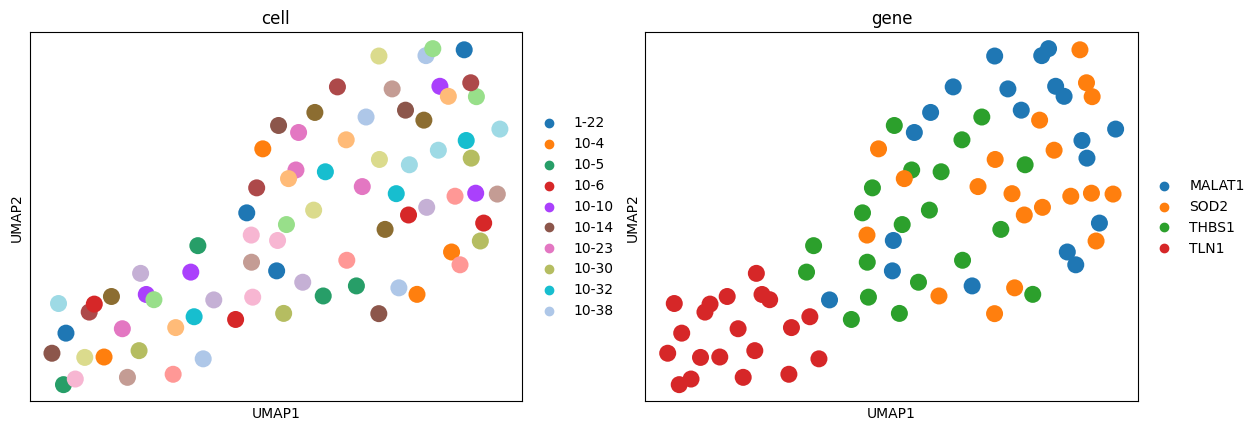

In [30]:
sc.pl.umap(ad, color=['cell', 'gene'], s=600)
